In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
default(grid = false)

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

In [4]:
xlim = (-5.0,5.0)
ylim = (-2.0,2.0)
k = 1.5; # factor to multiply grid spacing by to get point spacing

Δx, Δt = setstepsizes(Re)

(0.01, 0.005)

In [5]:
bl = BodyList()
tl = RigidTransform[]

RigidTransform[]

In [8]:
basicbody = Ellipse(0.5,0.5,k*Δx)

Circular body with 209 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [9]:
b1 = deepcopy(basicbody)
let
    cent = (-1.0,0.0)
    α = 0.0
    global T1 = RigidTransform(cent,α)
end
T1(b1) # transform the body to the current configuration

Circular body with 209 points and radius 0.5
   Current position: (-1.0,0.0)
   Current angle (rad): 0.0


In [10]:
push!(tl,T1)

1-element Array{RigidTransform,1}:
 Rigid-body transform
  Translation: (-1.0,0.0)
  Rotation angle (rad): 0.0


In [11]:
push!(bl,deepcopy(b1))

1-element Array{Body,1}:
 Circular body with 209 points and radius 0.5
   Current position: (-1.0,0.0)
   Current angle (rad): 0.0


In [12]:
b2 = deepcopy(basicbody)
let
    cent = (0.5,0.0)
    α = 0.0
    global T2 = RigidTransform(cent,α)
end
T2(b2) # transform the body to the current configuration

Circular body with 209 points and radius 0.5
   Current position: (0.5,0.0)
   Current angle (rad): 0.0


In [13]:
push!(tl,T2)

2-element Array{RigidTransform,1}:
 Rigid-body transform
  Translation: (-1.0,0.0)
  Rotation angle (rad): 0.0

 Rigid-body transform
  Translation: (0.5,0.0)
  Rotation angle (rad): 0.0


In [14]:
push!(bl,deepcopy(b2));

In [15]:
b3 = deepcopy(basicbody)
let
    cent = (3.0,0.0)
    α = 0.0
    global T3 = RigidTransform(cent,α)
end
T3(b3) # transform the body to the current configuration

Circular body with 209 points and radius 0.5
   Current position: (3.0,0.0)
   Current angle (rad): 0.0


In [16]:
push!(tl,T3)

3-element Array{RigidTransform,1}:
 Rigid-body transform
  Translation: (-1.0,0.0)
  Rotation angle (rad): 0.0

 Rigid-body transform
  Translation: (0.5,0.0)
  Rotation angle (rad): 0.0

 Rigid-body transform
  Translation: (3.0,0.0)
  Rotation angle (rad): 0.0


In [17]:
push!(bl,deepcopy(b3))

3-element Array{Body,1}:
 Circular body with 209 points and radius 0.5
   Current position: (-1.0,0.0)
   Current angle (rad): 0.0

 Circular body with 209 points and radius 0.5
   Current position: (0.5,0.0)
   Current angle (rad): 0.0

 Circular body with 209 points and radius 0.5
   Current position: (3.0,0.0)
   Current angle (rad): 0.0


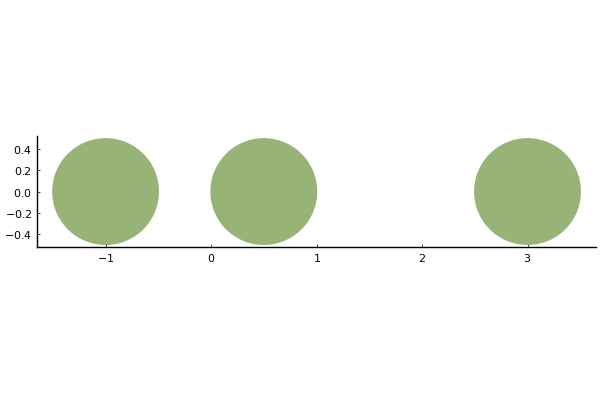

In [18]:
plot(bl)

In [19]:
X = VectorData(collect(bl));

In [20]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X,isstore=true)

Navier-Stokes system on a grid of size 1008 x 416

In [21]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);
xg, yg = coordinates(w₀,dx=Δx,I0=origin(sys))

(-5.035:0.01:5.035, -2.075:0.01:2.075)

In [22]:
x0 = (0.0,0.0)
A = 10.0
t0 = 2.0
sigt = 1.0
wf = PointForce(w₀,x0,A,t0,sigt,sys)

Transient point force applied on the Nodes{Dual,1008,416,Float64,Array{Float64,2}} field.
   strength = 10.0
   location = [0.0, 0.0]
   central time = 2.0
   half-interval = 1.0


In [23]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys) + wf(t)
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys)


@time solver = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

154.468999 seconds (20.71 M allocations: 99.148 GiB, 7.89% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,1008,416,Float64,Array{Float64,2}}
   Force of type VectorData{627,Float64,Array{Float64,1}}
   Time step size 0.005


In [24]:
t = 0.0
u = zero(w₀)

# Rate at which to store field data
tsample = 0.2

# Field data storage plan
S = StorePlan(tsample,"state"=>u,"time"=>t)
data_history = initialize_storage(S)

# Force data storage plan, stored every time step
F = StorePlan(timestep(sys),"f1x"=>sum(f.u,bl,1),"f1y"=>sum(f.v,bl,1),
                            "f2x"=>sum(f.u,bl,2),"f2y"=>sum(f.v,bl,2),
                            "f3x"=>sum(f.u,bl,3),"f3y"=>sum(f.v,bl,3),"time"=>t)
force_history = initialize_storage(F)
nothing

In [25]:
tsim = 20.0;

In [26]:
for ti in timerange(tsim,sys)
    global t, u, f = solver(t,u)
    
    fds = force(f,sys)
    
    store_data!(data_history,t,S,"state" => u, "time" => t)
    store_data!(force_history,t,F,"f1x" => sum(fds.u,bl,1),"f1y" => sum(fds.v,bl,1),
                                  "f2x" => sum(fds.u,bl,2),"f2y" => sum(fds.v,bl,2),
                                  "f3x" => sum(fds.u,bl,3),"f3y" => sum(fds.v,bl,3),"time" => t)
    
end
println("solution completed through time t = ",t)

solution completed through time t = 20.000000000000306


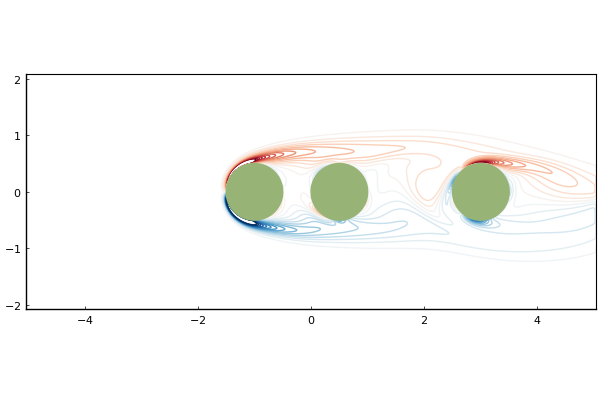

In [27]:
plot(vorticity(data_history["state"][end],sys),sys,levels=range(-10,10,length=30), color = :RdBu,clim=(-10,10))
plot!(bl)

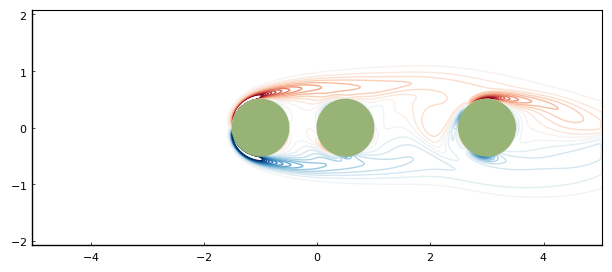

┌ Info: Saved animation to 
│   fn = /Users/fardinhaque/Documents/UCLArepository/tmp.gif
└ @ Plots /Users/fardinhaque/.julia/packages/Plots/YdauZ/src/animation.jl:104


Plots.AnimatedGif("/Users/fardinhaque/Documents/UCLArepository/tmp.gif")
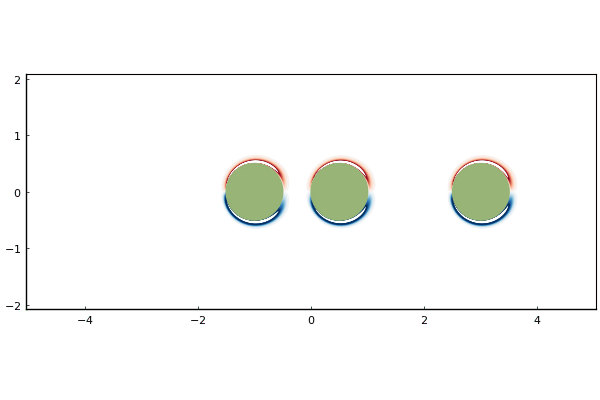

In [28]:
@gif for i = 1:length(data_history["state"])
    plot(vorticity(data_history["state"][i],sys),sys,levels=range(-10,10,length=30), color = :RdBu,clim=(-10,10))
    plot!(bl)
end

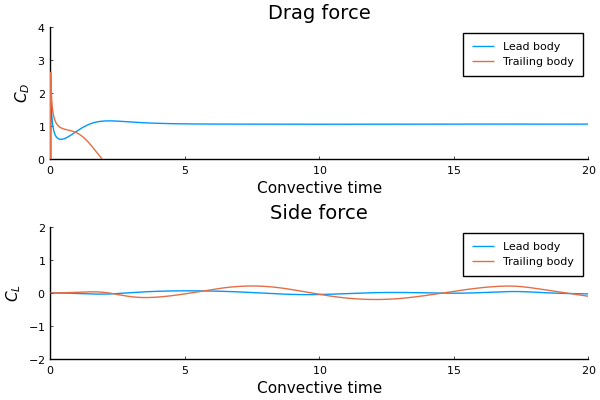

In [29]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[2],force_history["time"],2*force_history["f1y"],xlim=(0,20),ylim=(-2,2),xlabel="Convective time",ylabel="\$C_L\$",label="Lead body",title="Side force")
plot!(plt[1],force_history["time"],2*force_history["f1x"],xlim=(0,20),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",label="Lead body",title="Drag force")
plot!(plt[2],force_history["time"],2*force_history["f2y"],xlim=(0,20),ylim=(-2,2),xlabel="Convective time",ylabel="\$C_L\$",label="Trailing body")
plot!(plt[1],force_history["time"],2*force_history["f2x"],xlim=(0,20),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",label="Trailing body")
plt

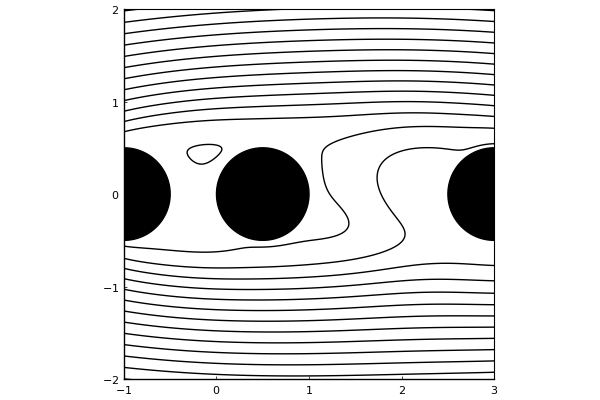

In [30]:
plot(streamfunction(data_history["state"][end],sys),sys,levels=range(-2,2,length=31), color = :black,clim=(-0.25,0.25),xlim=(-1,3),ylim=(-2,2))
plot!(bl,fillcolor=:black,linecolor=:black)